### Read in the data

What we're going to do:
* show the first few rows of the dataset
* plot a histogram for `cnt` column
* show the correlation between each column in the dataset with `cnt` column
* bundle similar times together, enabling the model to make better decisions

In [31]:
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


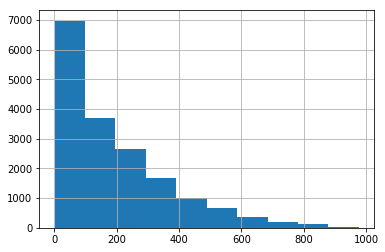

In [32]:
%matplotlib inline
bike_rentals.cnt.hist()

In [33]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [34]:
def assign_label(h):
    if h in range(6,13,1):
        return 1
    elif h in range(13,19,1):
        return 2
    elif h in range(19,25,1):
        return 3
    elif h in range(0,6,1):
        return 4

bike_rentals['time_label'] = bike_rentals.hr.apply(assign_label)
bike_rentals.time_label.head()

0    4
1    4
2    4
3    4
4    4
Name: time_label, dtype: int64

### Linear Regression

Linear Regression works best when predictors are linearly correlated to the target and also independent -- they don't change meaning when we combine them with each other. Linear Regression is fairly resistant to overfitting and also can be prone to underfitting the data, and not building a powerful enough model.
However, we'll ignore the `casual` and `registered` columns because `cnt` is derived from them.

### Error Metric

To evaluate the performance of machine learning algorithms, we'll use the MSE (_mean squared error_) metric. It works on continuous data which fits our data quite well.

In [35]:
train = bike_rentals.sample(frac=.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print(bike_rentals.shape[0], train.shape[0]+test.shape[0])

17379 17379


In [36]:
predictor_columns = list(bike_rentals.columns)
for col in ['casual', 'registered', 'dteday', 'cnt']:
    predictor_columns.remove(col)
predictor_columns

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[predictor_columns], train.cnt)
labels = lr.predict(test[predictor_columns])

mse = mean_squared_error(test.cnt, labels)
mse

16402.497093142552

### Considerations on the error

Since the MSE penalizes predicted values that are far away from the actual values, it means that some values are larger than the correct ones in `cnt`. 

### Decision tree algorithm

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like `maximum depth` and `minimum number of samples per leaf`.

In [40]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=3)
clf.fit(train[predictor_columns], train.cnt)
predictions = clf.predict(test[predictor_columns])

mse_tree = mean_squared_error(test.cnt, predictions)
mse_tree

3083.7511507479862

In [41]:
clf = DecisionTreeRegressor(min_samples_leaf=10, random_state=3)
clf.fit(train[predictor_columns], train.cnt)
predictions = clf.predict(test[predictor_columns])

mse_tree = mean_squared_error(test.cnt, predictions)
mse_tree

2697.4375946365744

In [42]:
clf = DecisionTreeRegressor(max_features=5, random_state=3)
clf.fit(train[predictor_columns], train.cnt)
predictions = clf.predict(test[predictor_columns])

mse_tree = mean_squared_error(test.cnt, predictions)
mse_tree

4373.6605293440734

### Considerations

By taking non linear predictors, we get much higher accuracy than linear regression. Also tweaking parameters like `min_samples_leaf` improves the error. 

### Random Forest algorithm

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. 
Random forests can still be prone to overfitting, so it's important to tune parameters like `maximum depth` and `minimum samples per leaf`.

In [43]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=4)
reg.fit(train[predictor_columns], train.cnt)
predictions = reg.predict(test[predictor_columns])

mse_reg = mean_squared_error(test.cnt, predictions)
mse_reg

1965.1591829689298

In [44]:
reg = RandomForestRegressor(min_samples_leaf=10, random_state=4)
reg.fit(train[predictor_columns], train.cnt)
predictions = reg.predict(test[predictor_columns])

mse_reg = mean_squared_error(test.cnt, predictions)
mse_reg

2367.3652329801125

### Final considerations

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.


### Further developments

Here are some potential next steps:
* Calculate additional features, such as:
  * An index combining temperature, humidity, and wind speed
* Try predicting `casual` and `registered` instead of `cnt`